### Préparation de l'environnement et chargement des données

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Models selections

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Métriques 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Standardisation 
from sklearn.preprocessing import StandardScaler

# Modèles linéaires
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Modèle de Support Vector Machin
from sklearn.svm import SVR

# Modèles ensemblistes 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

import xgboost as xgb


# Modèle de régression KNN
from sklearn.neighbors import KNeighborsRegressor

# Modèle dummy 
from sklearn.dummy import DummyRegressor

# Modèle deep learning (perceptron multi-couches) 
from sklearn.neural_network import MLPRegressor

# Feature Selection
import shap

#Timer
from timeit import default_timer as timer

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=3, n_jobs = -1, randomized_cv = False,random_state_cv = 0, randomized_n_iter = 10) :
    """ Cette fonction permet de tester et comparer en parallèle de nombreux modèles en utilisant la validation croisée. 
    Entrées : les Données d'entrainement (X et y), les données de test (X et y), un dictionnaire de paramètre (détaillé ci-dessous), 
              le nombre de 'fold' pour la validation croisée, le nombre de coeurs alloués (-1 : tous les coeurs).
              L'argument randomized_cv = True permet de lancer RandomizedSearchCV à la place de GridsearchCV. 
              Le random-state et le nombre d'itérations peuvent ensuite etre renseignés.
    Sortie : un dataframe contenant les modèles,les paramètres optimaux ,les top scores (R2) sur les données d'entrainements,
             le temps d'entrainement (lié à l'algorithme et au nombre d'hyperparamètre testé),
             le R2, MSE, RMSE et MAE des données de test. 

    Format du dictionnaire param_grid :

    param_grid ={
    'GradientBoosting_Reg' : 
        {
        'model' : GradientBoostingRegressor(),
        'params' : {
            'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'n_estimators': np.linspace(10, 200, 20,dtype=int)
                    }
        }, 
    'Lasso':{
        'model' : Lasso(),
        'params' : {
           'alpha': np.linspace(0.1, 5, 10),
           'tol' : [0.01],
           'max_iter':[10000]
                    }
        }
    }
    """
    
    scores=[]


    for model_name,mp in param_grid.items():
        if randomized_cv:
            model_compare = RandomizedSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False,n_jobs=n_jobs,random_state = random_state_cv, n_iter=randomized_n_iter)

        else: 
            model_compare = GridSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False,n_jobs=n_jobs)

        start = timer()
        model_compare.fit(X_train,y_train)
        end = timer()
        y_pred=model_compare.predict(X_test)
        scores.append({
            'model' : model_name,
            'top_params' : str(model_compare.best_params_),
            'top_score_train' : model_compare.best_score_.round(3),
            'fit_time' : end-start,
            'R2_test' : r2_score(y_test,y_pred).round(3),
            'MSE_test' : mean_squared_error(y_test,y_pred,squared=False).round(3),
            'RMSE_test' : mean_squared_error(y_test,y_pred).round(3),
            'MAE_test' : round(np.mean(abs(y_pred - y_test)), 3)
        })

    output = pd.DataFrame(scores).copy()
    
    return output

### 1. Prédiction de la consommation d'énergie 

In [4]:
# Chargement du dataframe
df = pd.read_csv(r"C:\Users\elodi\Downloads\EF_P4_anticipez-les-besoins-en-consommation-de-batiments-1_2024-10-24T160032\Anticipez les besoins en consommation de bâtiments_Frau_Elodie\DataCleaned.csv")

#### Comparaison des différents modèles

In [5]:
#Préparation d'un dictionnaire des paramètres pour la fonction regression_comparison
param_grid ={
    'Dummy_regression':{
        'model' : DummyRegressor(),
        'params' : {
            'strategy' : ['mean']
                    }
    },
    'linear_regression':{
        'model' : LinearRegression(),
        'params' : {
                    }
    },
    'Ridge':{
        'model' : Ridge(random_state=0),
        'params' : {
            'alpha': np.linspace(0.001, 10, 30)
                }
    },
    'Lasso':{
        'model' : Lasso(random_state=0),
        'params' : {
           'alpha': np.linspace(0.001, 10, 30),
           'tol' : [0.01],
           'max_iter':[10000]
                    }
    },
    'ElasticNet':{
        'model' : ElasticNet(random_state=0),
        'params' : {
            'alpha': np.linspace(0.001, 10, 30)
                    }
    },
    'SVR':{
        'model' : SVR(),
        'params' : {
        'C' : np.logspace(-2, 3, 6),
        'gamma' : np.logspace(-2, 1, 4)
                }
    },
    'KNN' : {
        'model' : KNeighborsRegressor(),
        'params' : {
        'n_neighbors':[3, 5, 7, 9, 11, 13, 15]  
            }
    },
    'Bagging_Reg' : {
        'model' : BaggingRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(10, 200, 20,dtype=int)
         },
    },
    'random_forest' : {
        'model' : RandomForestRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(10, 200, 20,dtype=int)
         }
    },
    'AdaBoost_Reg' : {
        'model' : AdaBoostRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(3, 1000, 20,dtype=int)
         }
    },
    'GradientBoosting_Reg' : {
        'model' : GradientBoostingRegressor(random_state=0),
        'params' : {
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 30,dtype=int)
         }
    },
    'XGBoost_reg' : {
        'model' : xgb.XGBRegressor(random_state=0),
        'params' : {
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 20,dtype=int)
         }
    },
    'Perceptron_reg' : {
        'model' : MLPRegressor(random_state=0),
        'params' : {
            'max_iter':[2000],
           # 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
                    }
    },
}

In [6]:
# Certains algorithmes comme la régression Lasso, Ridge et ElasticNet requiert une standardisation 
# des données (centré sur 0 et d'écart type 1)
# afin d'être pertinent sur la pondération des variables.

# Nous allons tester ici l'effet de la standardisation : 

lst_variables = ['Longitude','Latitude','ENERGYSTARScore',
                 'YearBuilt','Parking_per','Largest_UseType_per','NumberofFloors','NumberofBuildings','PropertyGFATotal']
                 
X = df.drop(columns=['TotalGHGEmissions','SiteEnergyUseWN(kBtu)'])
y = df['SiteEnergyUseWN(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Emission_sc = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=5)
Scores_Emission_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.019,3.719802,-0.000,1.230,1.513,0.969
1,linear_regression,{},0.837,0.848968,0.889,0.410,0.168,0.315
2,Ridge,{'alpha': 0.001},0.837,0.810123,0.889,0.410,0.168,0.315
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.841,0.190155,0.889,0.410,0.168,0.313
4,ElasticNet,{'alpha': 0.001},0.839,0.209834,0.889,0.410,0.168,0.313
5,SVR,"{'C': 100.0, 'gamma': 0.01}",0.812,1.422118,0.880,0.426,0.182,0.320
6,KNN,{'n_neighbors': 7},0.600,0.078784,0.694,0.680,0.463,0.492
7,Bagging_Reg,{'n_estimators': 180},0.770,5.690595,0.844,0.486,0.236,0.371
8,random_forest,{'n_estimators': 40},0.770,4.827039,0.843,0.488,0.238,0.379
9,AdaBoost_Reg,{'n_estimators': 475},0.708,12.438609,0.830,0.507,0.257,0.402


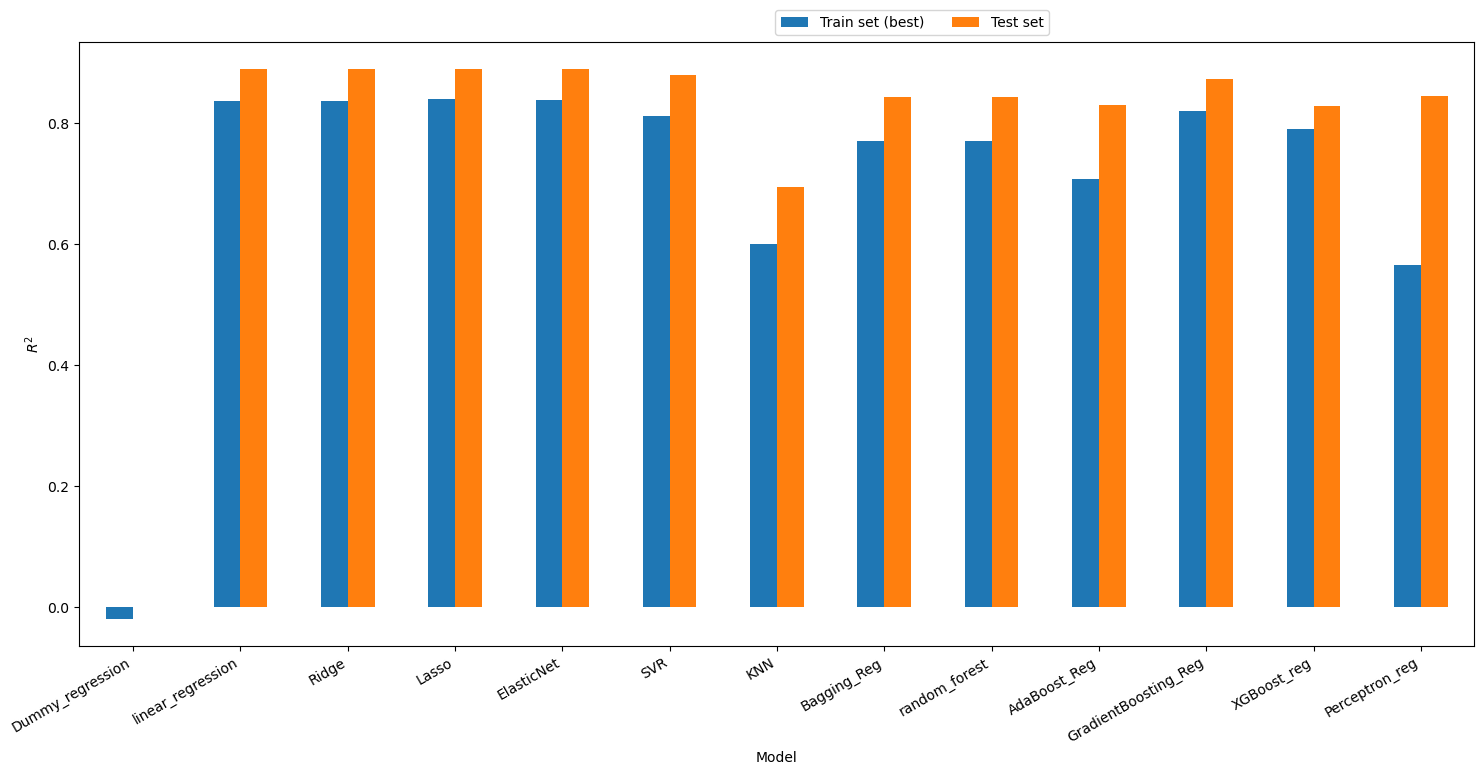

In [7]:
fig = plt.figure(figsize=(18,8),dpi=100)

Scores_Emission_sc[['model','top_score_train','R2_test']].plot(kind="bar", x='model', ax = plt.gca())
plt.legend(loc='lower right', labels=['Train set (best)', 'Test set'],ncol=2,bbox_to_anchor=(0.7, 1.0)
#title='Dataset :',
    )
plt.xlabel(xlabel='Model')
plt.ylabel(ylabel="$R^2$")
plt.xticks(rotation=30, ha='right')
plt.show()

In [8]:
# Changement des conditions de départ (nouveau random state pour le split des données)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Emission_sc = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=5)
Scores_Emission_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.010,0.013051,-0.019,1.345,1.809,1.049
1,linear_regression,{},0.813,0.013765,0.873,0.475,0.225,0.348
2,Ridge,{'alpha': 2.759344827586207},0.818,0.182021,0.862,0.495,0.245,0.353
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.818,0.226316,0.876,0.469,0.220,0.341
4,ElasticNet,{'alpha': 0.001},0.818,0.246416,0.874,0.473,0.224,0.346
5,SVR,"{'C': 10.0, 'gamma': 0.01}",0.829,1.349249,0.857,0.503,0.253,0.334
6,KNN,{'n_neighbors': 7},0.576,0.056727,0.630,0.811,0.658,0.588
7,Bagging_Reg,{'n_estimators': 120},0.779,5.903321,0.793,0.606,0.368,0.427
8,random_forest,{'n_estimators': 120},0.779,5.236936,0.791,0.609,0.371,0.428
9,AdaBoost_Reg,{'n_estimators': 317},0.742,13.534515,0.772,0.636,0.404,0.477


In [9]:
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUseWN(kBtu),Parking_per,Largest_UseType_per,PrimaryPropertyType_Data Center,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_BALLARD,Neighborhood_CENTRAL,Neighborhood_DELRIDGE,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,SteamUse(kBtu)_Usage,Electricity(kBtu)_Usage,NaturalGas(therms)_Usage
0,47.61220,-122.33799,1927,1.0,12,11.390023,60.0,5.525373,15.824652,0.000000,1.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1
1,47.61317,-122.33393,1996,1.0,11,11.547974,61.0,5.693261,15.974742,0.135405,0.81,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2,47.61412,-122.33664,1926,1.0,10,11.023878,56.0,5.660979,15.753792,0.000000,1.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1
3,47.61390,-122.33283,1926,1.0,11,11.326704,27.0,5.176940,15.617677,0.000000,0.98,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
4,47.60294,-122.33263,1904,1.0,15,12.007530,43.0,5.974217,16.468334,0.000000,1.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


#### Optimisation

In [10]:

param_grid ={
    'GradientBoosting_Reg' : {
        'model' : GradientBoostingRegressor(random_state=42),
        'params' : {
        "max_leaf_nodes": [2, 5, 10, 20, 50],
        'max_depth': [1,2,3,4,5,10, 15,20],
        'subsample' : np.arange(0.1, 1.1, 0.1),
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 30,dtype=int)
         }
    }
}

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Emission_sc  = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=10,random_state_cv=0, randomized_cv=True, randomized_n_iter= 200)

Scores_Emission_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,GradientBoosting_Reg,"{'subsample': 0.6, 'n_estimators': 400, 'max_l...",0.823,52.025518,0.872,0.441,0.194,0.333


In [12]:
# L'algorithme de Gradient Boosting ne requiert pas une standardisation des données.
# Test de l'algorithme sur les données non standardisées : 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

Scores_Emission  = Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=10,random_state_cv=0, randomized_cv=True, randomized_n_iter= 200)

Scores_Emission

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,GradientBoosting_Reg,"{'subsample': 0.7000000000000001, 'n_estimator...",0.825,51.310402,0.875,0.435,0.189,0.332


In [13]:
# Enregristrement des meilleurs hyper-paramètres :
best_params = eval(Scores_Emission.top_params[0])

In [14]:
# Entraînement du modèle définitif : 

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUseWN(kBtu)'])
y = df.dropna()['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)


GBR = GradientBoostingRegressor(random_state=42, **best_params)
GBR.fit(X_train, y_train)
y_pred=GBR.predict(X_test)


print("$R^2$ (Test Set) :" , r2_score(y_test,y_pred).round(3))
print("MSE (Test Set) :" , mean_squared_error(y_test,y_pred,squared=False).round(3))
print("RMSE (Test Set) :" , mean_squared_error(y_test,y_pred).round(3))
print("MAE (Test Set) :" , round(np.mean(abs(y_pred-y_test)), 3))

$R^2$ (Test Set) : 0.875
MSE (Test Set) : 0.435
RMSE (Test Set) : 0.189
MAE (Test Set) : 0.332


#### Analyse de la courbe d'apprentissage

In [15]:
from sklearn.model_selection import learning_curve

# La courbe d'apprentissage (learning curve) permet de tester la précision du modèle sur des échantillons du dataframe de plus en plus grand. 
N, train_score, val_score = learning_curve(GBR, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=10)

train_score = pd.DataFrame(train_score, index = N).T.melt()
val_score = pd.DataFrame(val_score, index = N).T.melt()

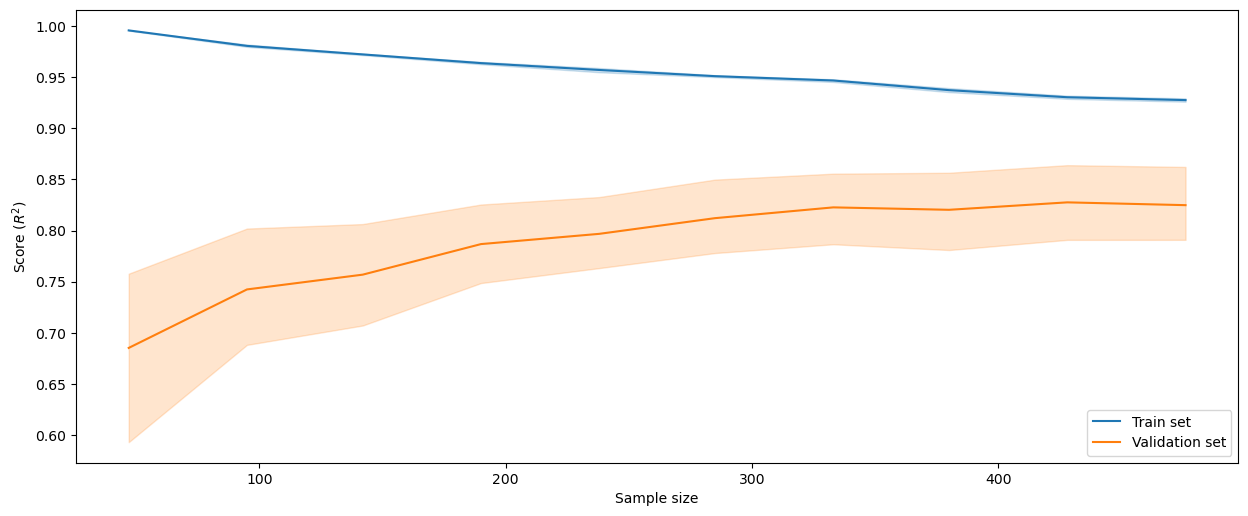

In [16]:
plt.figure(figsize=(15,6),dpi=100)
sns.lineplot(data= train_score, x="variable", y="value", label='Train set')
sns.lineplot(data= val_score, x="variable", y="value",label= 'Validation set')
#plt.xlim([0, 601])
plt.xlabel("Sample size")
plt.ylabel("Score ($R^2$)")
plt.legend(loc = 'lower right')
plt.show()

Analyse de l'importance des variables

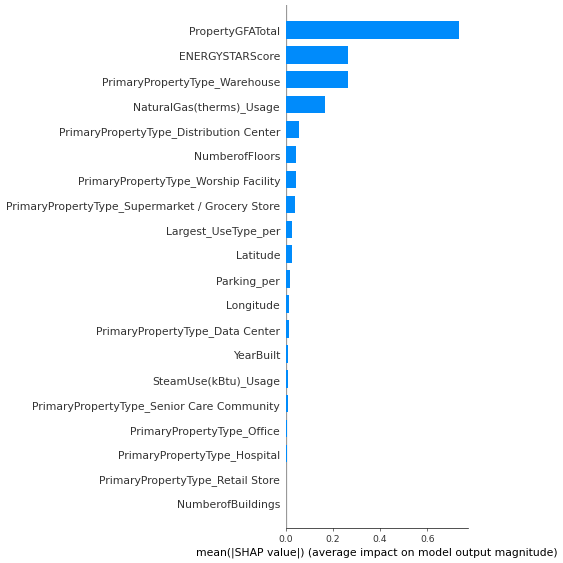

In [17]:
# L'importance des variables sera ici testé par la méthode de Shapley
# Plus la valeur SHAP est importante, plus la variable affecte la valeur prédite. 
shap_values = shap.TreeExplainer(GBR).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(GBR).shap_interaction_values(X_test)
plt.figure(figsize=(10,6),dpi=60)
shap.summary_plot(shap_values, X_test, plot_type="bar")

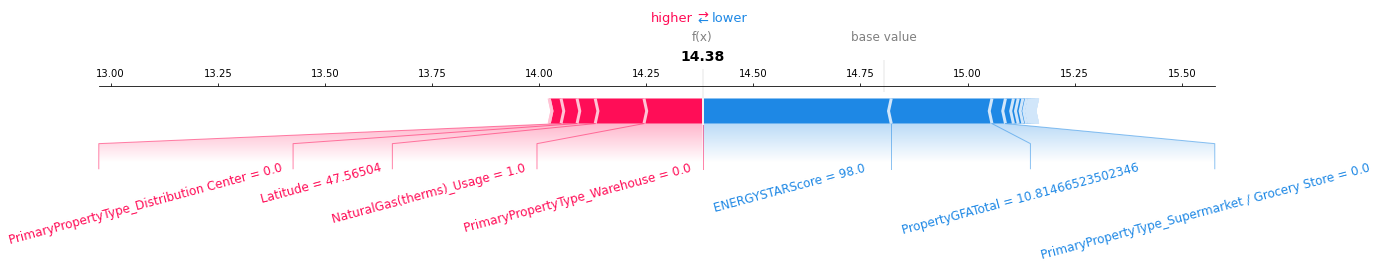

In [18]:
# Représentation de l'effet des variables sur un bâtiment
shap.initjs()
i = 100
shap.force_plot(shap.TreeExplainer(GBR).expected_value, shap_values[i], X_test.iloc[i,:],show=False,matplotlib=True,text_rotation=15).savefig('scratch.png')

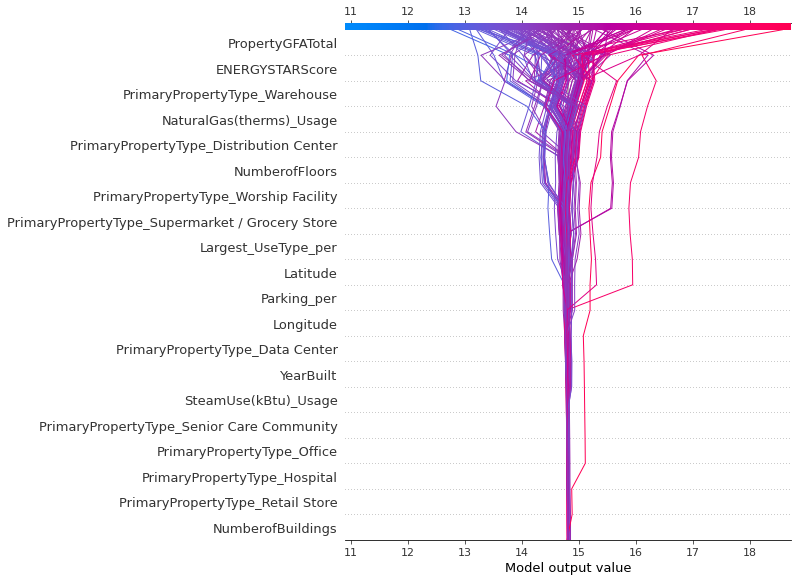

In [19]:
# Représentation de l'effet des variables sur tout le dataframe

shap.decision_plot(shap.TreeExplainer(GBR).expected_value, shap_values, features = X_test.columns)

### Importances des variables locale

1er exemple avec les Data Center

In [20]:
explainer = shap.TreeExplainer(GBR)

instance_to_explain = X_test['PrimaryPropertyType_Data Center']

# Calculer les valeurs SHAP pour cette instance
shap_values_local = explainer.shap_values(instance_to_explain)

In [21]:
shap.initjs()  
shap.force_plot(explainer.expected_value, shap_values_local, instance_to_explain)

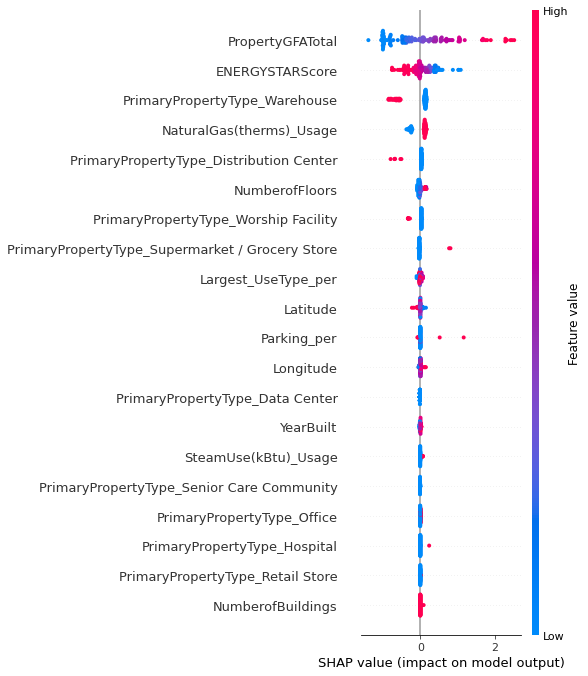

In [22]:
shap_values = explainer.shap_values(X_test)

# Visualisation globale des valeurs SHAP 
shap.summary_plot(shap_values, X_test, plot_type="dot")

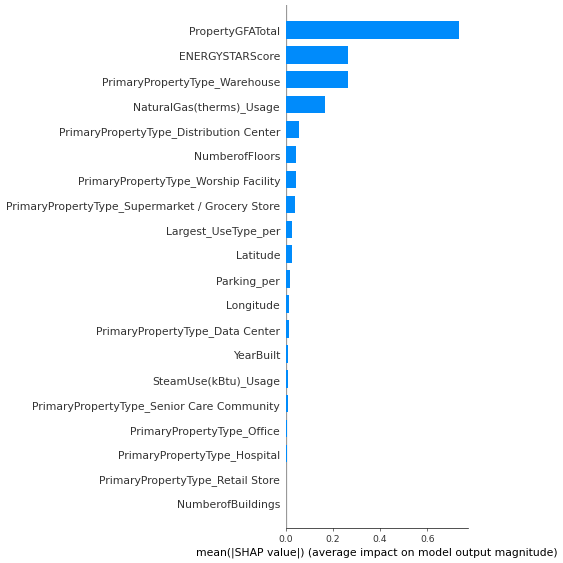

In [23]:
shap_values = shap.TreeExplainer(GBR).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(GBR).shap_interaction_values(X_test)
plt.figure(figsize=(10,6),dpi=60)
shap.summary_plot(shap_values, X_test, plot_type="bar")

2ème exemple avec PrimaryPropertyType_Office

In [24]:
explainer_2 = shap.TreeExplainer(GBR)
instance_to_explain_2 = X_test['PrimaryPropertyType_Office']

# Calculer les valeurs SHAP pour cette instance
shap_values_local_2 = explainer_2.shap_values(instance_to_explain_2)

In [25]:
shap.initjs()  
shap.force_plot(explainer_2.expected_value, shap_values_local_2, instance_to_explain_2)

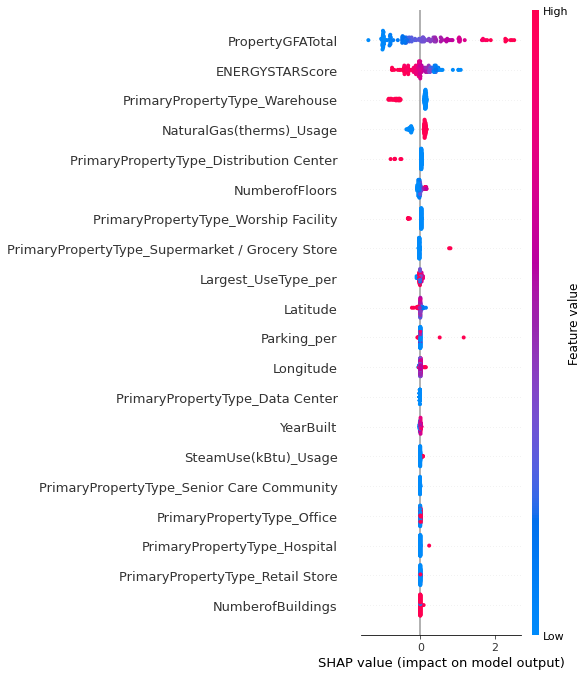

In [26]:
shap_values = explainer_2.shap_values(X_test)

# Visualisation globale des valeurs SHAP 
shap.summary_plot(shap_values, X_test, plot_type="dot")

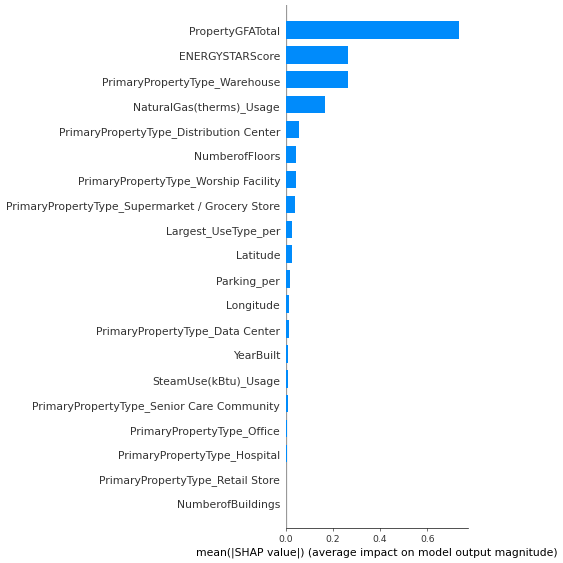

In [27]:
shap_values = shap.TreeExplainer(GBR).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(GBR).shap_interaction_values(X_test)
plt.figure(figsize=(10,6),dpi=60)
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### Entraînement du modèle sans et avec la variable ENERGYSTARScore

In [28]:
# Entraînement du modèle sans la variable ENERGYSTARScore

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUseWN(kBtu)'])
y = df.dropna()['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

GBR2 = GradientBoostingRegressor(random_state=42, **best_params)
GBR2.fit(X_train, y_train)
y_pred2=GBR2.predict(X_test)


print("$R^2$ (Test Set) :" , r2_score(y_test,y_pred2).round(3))
print("MSE (Test Set) :" , mean_squared_error(y_test,y_pred2,squared=False).round(3))
print("RMSE (Test Set) :" , mean_squared_error(y_test,y_pred2).round(3))
print("MAE (Test Set) :" , round(np.mean(abs(y_pred2-y_test)), 3))

$R^2$ (Test Set) : 0.875
MSE (Test Set) : 0.435
RMSE (Test Set) : 0.189
MAE (Test Set) : 0.332


In [29]:
# Entraînement du modèle avec la variable ENERGYSTARScore

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUseWN(kBtu)', 'ENERGYSTARScore'])
y = df.dropna()['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)


GBR = GradientBoostingRegressor(random_state=42, **best_params)
GBR.fit(X_train, y_train)
y_pred=GBR.predict(X_test)


print("$R^2$ (Test Set) :", r2_score(y_test,y_pred).round(3))
print("MSE (Test Set) :", mean_squared_error(y_test,y_pred,squared=False).round(3))
print("RMSE (Test Set) :", mean_squared_error(y_test,y_pred).round(3))
print("MAE (Test Set) :", round(np.mean(abs(y_pred-y_test)), 3))

$R^2$ (Test Set) : 0.77
MSE (Test Set) : 0.59
RMSE (Test Set) : 0.349
MAE (Test Set) : 0.464


#### Analyse des valeurs prédites vs valeurs vraies

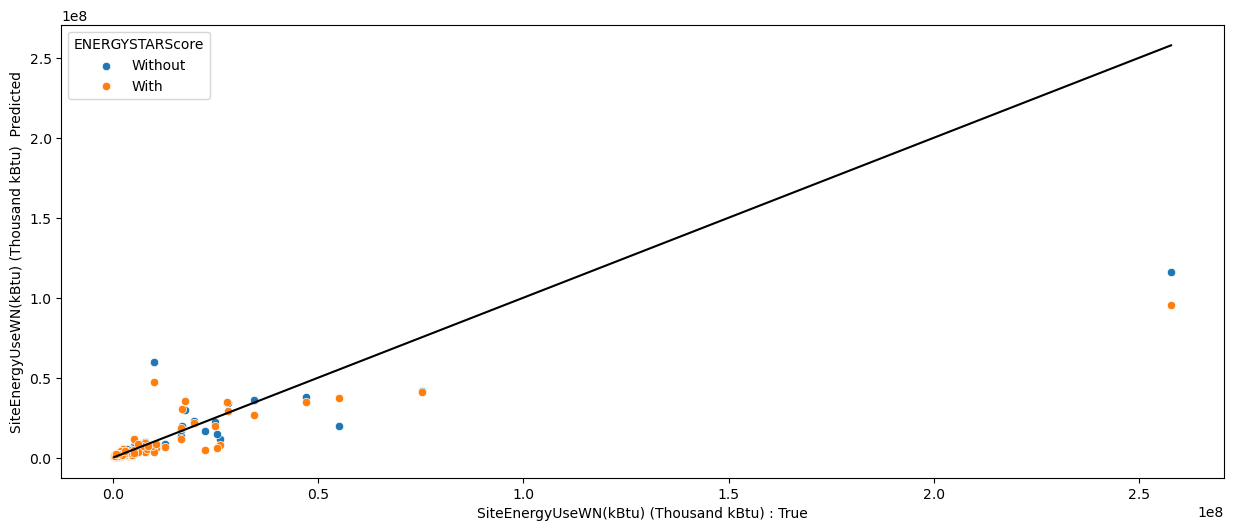

In [30]:
plt.figure(figsize=(15,6),dpi=100)

sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred2))
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred))
plt.legend(title='ENERGYSTARScore', loc='upper left', labels=['Without', 'With'])
sns.lineplot(x=np.expm1(y_test), y=np.expm1(y_test),color="black")

plt.xlabel("SiteEnergyUseWN(kBtu) (Thousand kBtu) : True")
plt.ylabel("SiteEnergyUseWN(kBtu) (Thousand kBtu)  Predicted")
plt.show()